<a href="https://colab.research.google.com/github/Champioa00/LAB1/blob/master/Anthony_Champion_LAB1_IST718.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Anthony Champion ##
## IST 718 - LAB 1 ##
## 1/30/2022 ##
## Question: How can we recommend the best salary for our next head football coach? ##

In [2]:
## Load Required Packages ##
import pandas as pd
import io
import numpy as np 
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
## Load Coach Data Frame ##
coachdf = pd.read_csv('https://raw.githubusercontent.com/Champioa00/LAB1/master/Coaches9.csv')


In [4]:
## Explore Coach Data Frame ## 
print(coachdf.shape)
print(coachdf.info())
coachdf.head()

(129, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   School        129 non-null    object
 1   Conference    129 non-null    object
 2   Coach         129 non-null    object
 3   SchoolPay     129 non-null    object
 4   TotalPay      129 non-null    object
 5   Bonus         129 non-null    object
 6   BonusPaid     129 non-null    object
 7   AssistantPay  129 non-null    object
 8   Buyout        129 non-null    object
dtypes: object(9)
memory usage: 9.2+ KB
None


,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--
1,Akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500"
2,Alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000"
3,Alabama at Birmingham,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500"
4,Appalachian State,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417"


The starting point of this analysis is the coaching dataset. The first pass data exploration shows there are 9 columns and 129 unique observations. Looking deeper, it's clear the numeric values all have a dollar sign ($) in front of them. There also looks to be some values are missing in BonusPaid and Buyout. We will need to add some additional data points as well as perform some data transformation and cleansing.

In [5]:
## Look at one conference and determine what variables need to be cleaned ##
coachdf[coachdf['Conference']=='SEC']

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
2,Alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000"
7,Arkansas,SEC,Chad Morris,"$3,500,000","$3,500,000","$1,000,000",--,$0,"$12,500,000"
10,Auburn,SEC,Gus Malzahn,"$6,700,000","$6,705,656","$1,400,000","$375,000",$0,"$32,143,750"
31,Florida,SEC,Dan Mullen,"$6,070,000","$6,070,000","$925,000",--,$0,"$12,000,000"
36,Georgia,SEC,Kirby Smart,"$6,603,600","$6,603,600","$1,150,000","$1,350,000",$0,"$27,917,500"
49,Kentucky,SEC,Mark Stoops,"$4,000,000","$4,013,600","$3,100,000","$300,000",$0,"$15,625,000"
55,LSU,SEC,Ed Orgeron,"$3,500,000","$3,500,000","$1,575,000","$100,000",$0,"$5,291,667"
66,Mississippi,SEC,Matt Luke,"$3,000,000","$3,000,000","$1,550,000",--,$0,$0
67,Mississippi State,SEC,Joe Moorhead,"$2,600,000","$2,600,000","$1,350,000",--,$0,$0
68,Missouri,SEC,Barry Odom,"$2,350,000","$2,350,000","$1,025,000","$375,000",$0,"$1,912,500"


All the dollar signs and commas need to be removed as well as the "--" data points converted to 0. Once completed we will start to introduce addtional datasets into the analysis.

In [6]:
## Select all the numeric columns ## 
num_columns = ['SchoolPay', 'TotalPay', 'Bonus', 'BonusPaid', 'AssistantPay', 'Buyout']

## Remove $, ",", and replace "--" with "0" ## 
for i in num_columns:
    coachdf[i] = coachdf[i].replace('[$,]', '', regex=True)
    coachdf[i] = coachdf[i].replace('[--]', '0', regex=True)
    coachdf[i] = coachdf[i].astype(float)

## Check Coach Dataset ## 
coachdf[coachdf['Conference']=='SEC']

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
2,Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,0.0,33600000.0
7,Arkansas,SEC,Chad Morris,3500000.0,3500000.0,1000000.0,0.0,0.0,12500000.0
10,Auburn,SEC,Gus Malzahn,6700000.0,6705656.0,1400000.0,375000.0,0.0,32143750.0
31,Florida,SEC,Dan Mullen,6070000.0,6070000.0,925000.0,0.0,0.0,12000000.0
36,Georgia,SEC,Kirby Smart,6603600.0,6603600.0,1150000.0,1350000.0,0.0,27917500.0
49,Kentucky,SEC,Mark Stoops,4000000.0,4013600.0,3100000.0,300000.0,0.0,15625000.0
55,LSU,SEC,Ed Orgeron,3500000.0,3500000.0,1575000.0,100000.0,0.0,5291667.0
66,Mississippi,SEC,Matt Luke,3000000.0,3000000.0,1550000.0,0.0,0.0,0.0
67,Mississippi State,SEC,Joe Moorhead,2600000.0,2600000.0,1350000.0,0.0,0.0,0.0
68,Missouri,SEC,Barry Odom,2350000.0,2350000.0,1025000.0,375000.0,0.0,1912500.0


Add in addtional data sets to help with the analysis
1.) Coaches Data Set - Provided by 2SU
2.) Records Data Set - www.espn.com
3.) Stadium Data Set - https://www.collegegridirons.com/comparisons-by-capacity/
4.) Graduation Data Set - Provided by 2SU

In [7]:
## Load Records and Points Metrics by team and conference ##
recordsdf = pd.read_csv('https://raw.githubusercontent.com/Champioa00/LAB1/master/records.csv')

In [8]:
## Explore Coach Data Frame ## 
print(recordsdf.shape)
print(recordsdf.info())
recordsdf.head()

(130, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SCHOOL                     130 non-null    object 
 1   CONFERENCE                 130 non-null    object 
 2   W                          130 non-null    int64  
 3   L                          130 non-null    int64  
 4   PF                         130 non-null    int64  
 5   PA                         130 non-null    int64  
 6   AVG_POINTS_PER _GAME       130 non-null    float64
 7   DEF_ AVG_POINTS_PER _GAME  130 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 8.2+ KB
None


,SCHOOL,CONFERENCE,W,L,PF,PA,AVG_POINTS_PER _GAME,DEF_ AVG_POINTS_PER _GAME
0,Cincinnati,AAC,13,1,516,236,36.9,16.9
1,Houston,AAC,12,2,508,286,36.3,20.4
2,UCF,AAC,9,4,478,333,36.8,25.6
3,SMU,AAC,8,4,461,341,38.4,28.4
4,East Carolina,AAC,7,5,356,315,29.7,26.3


In [9]:
## Clean up Numeric Columns ## 
## Select all the numeric columns ## 
recordssdf_num_columns = ['W', 'L', 'PF', 'PA']

## Remove $, ",", and replace "--" with "0" ## 
for i in recordssdf_num_columns:
    recordsdf[i] = recordsdf[i].astype(float)

## Check to see if the number format changed to float ##
print(recordsdf.shape)
print(recordsdf.info())

(130, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SCHOOL                     130 non-null    object 
 1   CONFERENCE                 130 non-null    object 
 2   W                          130 non-null    float64
 3   L                          130 non-null    float64
 4   PF                         130 non-null    float64
 5   PA                         130 non-null    float64
 6   AVG_POINTS_PER _GAME       130 non-null    float64
 7   DEF_ AVG_POINTS_PER _GAME  130 non-null    float64
dtypes: float64(6), object(2)
memory usage: 8.2+ KB
None


In [10]:
## Clean the Conference Data in the Coaches and Records ##

print(len(coachdf.Conference.unique()), coachdf.Conference.unique())
print(len(recordsdf.CONFERENCE.unique()), recordsdf.CONFERENCE.unique())

11 ['Mt. West' 'MAC' 'SEC' 'C-USA' 'Sun Belt' 'Pac-12' 'Ind.' 'Big 12' 'ACC'
 'AAC' 'Big Ten']
11 ['AAC' 'ACC' 'Big 12' 'Big Ten' 'C-USA' 'FBS Independent' 'MAC'
 'Mountain West' 'Pac-12' 'SEC' 'Sun Belt']


It looks like both the coach and record file have the same amount of conferences, lets look deeper and make sure they are fully aligned.

In [11]:
## Align the Conference Data ##

recordsdf_names = ['AAC','ACC','Big 12' ,'Big Ten' ,'C-USA', 'FBS Independent' ,'MAC' ,'Mountain West', 'Pac-12' ,'SEC' ,'Sun Belt']
new_name =        ['AAC' ,'ACC' ,'Big 12', 'Big Ten', 'C-USA' ,'Ind.', 'MAC', 'Mt. West' ,'Pac-12', 'SEC' ,'Sun Belt']  

recordsdf['CONFERENCE']=recordsdf['CONFERENCE'].replace(recordsdf_names, new_name, regex=False)


In [12]:
recordsdf_names

['AAC',
 'ACC',
 'Big 12',
 'Big Ten',
 'C-USA',
 'FBS Independent',
 'MAC',
 'Mountain West',
 'Pac-12',
 'SEC',
 'Sun Belt']

In [13]:
## Check to see if Conference change worked ## 
recordsdf[recordsdf['CONFERENCE']=='Ind.']


,SCHOOL,CONFERENCE,W,L,PF,PA,AVG_POINTS_PER _GAME,DEF_ AVG_POINTS_PER _GAME
63,Notre Dame,Ind.,11.0,2.0,458.0,256.0,35.2,19.7
64,BYU,Ind.,10.0,3.0,430.0,322.0,33.1,24.8
65,Army West Point,Ind.,9.0,4.0,427.0,290.0,32.8,22.3
66,Liberty,Ind.,8.0,5.0,437.0,280.0,33.6,21.5
67,New Mexico St.,Ind.,2.0,10.0,269.0,485.0,22.4,40.4
68,Massachusetts,Ind.,1.0,11.0,196.0,517.0,16.3,43.1
69,UConn,Ind.,1.0,11.0,187.0,462.0,15.6,38.5



Looks like Conference for both the coaches and records data sets are the same, now lets load in some data set to help find our answer.  Next up is stadium information

In [14]:
## Load and Explore Stadium Dataset ##
stadiumdf = pd.read_csv('https://raw.githubusercontent.com/Champioa00/LAB1/master/Stadium.csv')

## Explore Stadium Data Frame ## 
print(stadiumdf.shape)
print(stadiumdf.info())
stadiumdf.head()

(131, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Stadium     131 non-null    object
 1   College     131 non-null    object
 2   Conference  131 non-null    object
 3   Capacity    131 non-null    int64 
 4   Opened      131 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 5.2+ KB
None


,Stadium,College,Conference,Capacity,Opened
0,Michigan Stadium,Michigan,Big Ten,107601,1927
1,Beaver Stadium,Penn State,Big Ten,106572,1960
2,Ohio Stadium,Ohio State,Big Ten,104944,1922
3,Kyle Field,Texas A&M,SEC,102733,1904
4,Neyland Stadium,Tennessee,SEC,102521,1921


The Stadium dataset looks to have the needed School and Conference fields, as well as 131 records.  Let's take a deeper dive into the Conference Names and align those to our coaches and records datasets.

In [15]:
## Clean the data and change numeric fields ##
## Clean up Numeric Columns ## 
## Select all the numeric columns ## 
stadiumdf_num_columns = ['Capacity']

# Change to numeric ## 
for i in stadiumdf_num_columns:
    stadiumdf[i] = stadiumdf[i].astype(float)

## Check to see if the number format changed to float ##
print(stadiumdf.shape)
print(stadiumdf.info())

(131, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Stadium     131 non-null    object 
 1   College     131 non-null    object 
 2   Conference  131 non-null    object 
 3   Capacity    131 non-null    float64
 4   Opened      131 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 5.2+ KB
None


In [16]:
## Align the Conference with Coaches and Records Dataframe ## 
print(len(coachdf.Conference.unique()), coachdf.Conference.unique())
print(len(recordsdf.CONFERENCE.unique()), recordsdf.CONFERENCE.unique())
print(len(stadiumdf.Conference.unique()), stadiumdf.Conference.unique())

11 ['Mt. West' 'MAC' 'SEC' 'C-USA' 'Sun Belt' 'Pac-12' 'Ind.' 'Big 12' 'ACC'
 'AAC' 'Big Ten']
11 ['AAC' 'ACC' 'Big 12' 'Big Ten' 'C-USA' 'Ind.' 'MAC' 'Mt. West' 'Pac-12'
 'SEC' 'Sun Belt']
11 ['Big Ten' 'SEC' 'Big 12' 'Pac 12' 'ACC' 'Independent' 'CUSA'
 'Mountain West' 'MAC' 'AAC' 'Sun Belt']


In [17]:
## All three have 11 unique Conferences, just need to rename a couple conferences ##

stadiumdf_names = ['AAC' ,'ACC' ,'Big 12', 'Big Ten', 'CUSA', 'Independent', 'MAC', 'Mountain West', 'Pac 12', 'SEC', 'Sun Belt']

stadiumdf['Conference']=stadiumdf['Conference'].replace(stadiumdf_names, new_name, regex=False)

print(len(coachdf.Conference.unique()), coachdf.Conference.unique())
print(len(recordsdf.CONFERENCE.unique()), recordsdf.CONFERENCE.unique())
print(len(stadiumdf.Conference.unique()), stadiumdf.Conference.unique())

11 ['Mt. West' 'MAC' 'SEC' 'C-USA' 'Sun Belt' 'Pac-12' 'Ind.' 'Big 12' 'ACC'
 'AAC' 'Big Ten']
11 ['AAC' 'ACC' 'Big 12' 'Big Ten' 'C-USA' 'Ind.' 'MAC' 'Mt. West' 'Pac-12'
 'SEC' 'Sun Belt']
11 ['Big Ten' 'SEC' 'Big 12' 'Pac-12' 'ACC' 'Ind.' 'C-USA' 'Mt. West' 'MAC'
 'AAC' 'Sun Belt']


Time to add the final dataset, Graduation meterics

In [18]:
## Load and Explore Graduation Dataset ##
graddf = pd.read_csv('https://raw.githubusercontent.com/Champioa00/LAB1/master/GradRate.csv')

## Explore Graduation Data Frame ## 
print(graddf.shape)
print(graddf.info())
graddf.head()

(256, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Cohort Year  256 non-null    int64 
 1   School       256 non-null    object
 2   Conference   256 non-null    object
 3   Sport        256 non-null    object
 4   State        256 non-null    object
 5   GSR          256 non-null    int64 
 6   FGR          256 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 14.1+ KB
None


,Cohort Year,School,Conference,Sport,State,GSR,FGR
0,2014,Abilene Christian University,Southland Conference,Football,TX,75,51
1,2014,University of Akron,Mid-American Conference,Football,OH,79,76
2,2014,Alabama A&M University,Southwestern Athletic Conf.,Football,AL,62,54
3,2014,Alabama State University,Southwestern Athletic Conf.,Football,AL,71,42
4,2014,University of Alabama,Southeastern Conference,Football,AL,86,65


In [19]:
## Clean the data and change numeric fields ##
## Clean up Numeric Columns ## 
## Select all the numeric columns ## 
graddf_num_columns = ['GSR' , 'FGR']

# Change to numeric ## 
for i in graddf_num_columns:
    graddf[i] = graddf[i].astype(float)

## Check to see if the number format changed to float ##
print(graddf.shape)
print(graddf.info())

(256, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cohort Year  256 non-null    int64  
 1   School       256 non-null    object 
 2   Conference   256 non-null    object 
 3   Sport        256 non-null    object 
 4   State        256 non-null    object 
 5   GSR          256 non-null    float64
 6   FGR          256 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 14.1+ KB
None


In [20]:
## Align the Conference with Coaches and Records Dataframe ## 
print(len(graddf.Conference.unique()), graddf.Conference.unique())
new_name

25 ['Southland Conference' 'Mid-American Conference'
 'Southwestern Athletic Conf.' 'Southeastern Conference' 'Conference USA'
 'Colonial Athletic Association' 'Sun Belt Conference' 'Pac-12 Conference'
 'Ohio Valley Conference' 'Big South Conference' 'Big 12 Conference'
 'Mid-Eastern Athletic Conf.' 'Mountain West Conference'
 'Atlantic Coast Conference' 'Independent' 'The Ivy League'
 'Northeast Conference' 'Patriot League' 'Pioneer Football League'
 'Big Sky Conference' 'American Athletic Conference' 'Southern Conference'
 'Missouri Valley Football Conference' 'Big Ten Conference'
 'Horizon League']


['AAC',
 'ACC',
 'Big 12',
 'Big Ten',
 'C-USA',
 'Ind.',
 'MAC',
 'Mt. West',
 'Pac-12',
 'SEC',
 'Sun Belt']

In [21]:
## Transform Conference Column ##

grad_old_name = ['Southland Conference' ,'Mid-American Conference' ,'Southwestern Athletic Conf.' ,'Southeastern Conference' ,'Conference USA' ,'Colonial Athletic Association' ,
'Sun Belt Conference' ,'Pac-12 Conference' ,'Ohio Valley Conference' ,'Big South Conference' ,'Big 12 Conference' ,'Mid-Eastern Athletic Conf.' ,'Mountain West Conference' 
,'Atlantic Coast Conference' ,'Independent' ,'The Ivy League' ,'Northeast Conference' ,'Patriot League' ,'Pioneer Football League' ,'Big Sky Conference' ,'American Athletic Conference'
,'Southern Conference', 'Missouri Valley Football Conference' ,'Big Ten Conference', 'Horizon League']

grad_new_name = ['SLC', 'MAC', 'SWAC', 'SEC', 'C-USA', 'CAA', 'Sun Belt', 'Pac-12', 'OVC', 'Big South', 'Big 12', 'MEAC', 'Mt. West', 'ACC', 'Ind.','IVY', 'NEC', 'PAT', 'PFL', 
                 'Big Sky', 'AAC', 'SOCON', 'MVFC', 'Big Ten' , 'HOL']


graddf['Conference'] = graddf['Conference'].replace(grad_old_name, grad_new_name, regex=False)

## Check to see if Conference change worked ## 
graddf[graddf['Conference']=='IVY']

,Cohort Year,School,Conference,Sport,State,GSR,FGR
23,2014,Brown University,IVY,Football,RI,95.0,0.0
45,2014,Columbia University-Barnard College,IVY,Football,NY,99.0,0.0
47,2014,Cornell University,IVY,Football,NY,97.0,0.0
48,2014,Dartmouth College,IVY,Football,NH,100.0,0.0
76,2014,Harvard University,IVY,Football,MA,98.0,0.0
162,2014,University of Pennsylvania,IVY,Football,PA,91.0,90.0
166,2014,Princeton University,IVY,Football,NJ,99.0,100.0
244,2014,Yale University,IVY,Football,CT,98.0,0.0


In [22]:
## Align all team names ##
recordsdf['SCHOOL'] = recordsdf['SCHOOL'].replace('UCF', 'Central Florida', regex=False)
recordsdf['SCHOOL'] = recordsdf['SCHOOL'].replace('Miami (FL)', 'Miami (Fla.)', regex=False)
recordsdf['SCHOOL'] = recordsdf['SCHOOL'].replace(['UTSA', 'UTEP', 'Southern Miss'], ['Texas-San Antonio', 'Texas-El Paso', 'Southern Mississippi'], regex=False)

recordsdf['SCHOOL'] = recordsdf['SCHOOL'].replace(['App State',  'Arizona St.',  'Arkansas St.', 'Army West Point', 'Ball St.'], 
                                                  ['Appalachian State',  'Arizona State',  'Arkansas State', 'Army', 'Ball State' ], regex=False)

recordsdf['SCHOOL'] = recordsdf['SCHOOL'].replace(['Boise St.',  'BYU',  'Central Mich.', 'Colorado St.',  'Eastern Mich.',  'FIU',  'Fla. Atlantic'],
                                                  ['Boise State',  'Brigham Young',  'Central Michigan', 'Colorado State',  'Eastern Michigan',  'Florida International',  'Florida Atlantic'], 
                                                  regex=False)

recordsdf['SCHOOL'] = recordsdf['SCHOOL'].replace(['Florida St.',  'Fresno St.',  'Ga. Southern', 'Georgia St.',  'Iowa St.',  'Kansas St.',  'Kent St.'],
                                                  ['Florida State',  'Fresno State',  'Georgia Southern', 'Georgia State',  'Iowa State',  'Kansas State',  'Kent State'], regex=False)

recordsdf['SCHOOL'] = recordsdf['SCHOOL'].replace(['Louisiana',  'Miami (OH)',  'Michigan St.', 'Middle Tenn.',  'Mississippi St.',  'NC State',  'New Mexico St.'],
                                                  ['Louisiana-Lafayette',  'Miami (Ohio)',  'Michigan State', 'Middle Tennessee',  'Mississippi State',  'North Carolina State',  'New Mexico State'], 
                                                  regex=False)

recordsdf['SCHOOL'] = recordsdf['SCHOOL'].replace(['NIU',  'Ohio St.',  'Oklahoma St.', 'Ole Miss',  'Oregon St.',  'Penn St.',  'San Diego St.'],
                                                  ['Northern Illinois',  'Ohio State',  'Oklahoma State', 'Mississippi',  'Oregon State',  'Penn State',  'San Diego State'], regex=False)

recordsdf['SCHOOL'] = recordsdf['SCHOOL'].replace(['San Jose St.',  'South Fla.',  'Southern Miss.', 'TCU',  'Texas St.',  'UAB',  'UConn'],
                                                  ['San Jose State',  'South Florida',  'Southern Methodist', 'Texas Christian',  'Texas State',  'Alabama at Birmingham',  'Connecticut'], 
                                                  regex=False)

recordsdf['SCHOOL'] = recordsdf['SCHOOL'].replace(['ULM',  'UNLV',  'Utah St.', 'Washington St.',  'Western Ky.',  'Western Mich.'],
                                                  ['Louisiana-Monroe',  'Nevada-Las Vegas',  'Utah State', 'Washington State',  'Western Kentucky',  'Western Michigan'], regex=False)

stadiumdf['College'] = stadiumdf['College'].replace(['USC',  'UAB',  'Miami',  'UTSA',  'BYU',  'NC State',  'UTEP',  'TCU',  'UNLV',  'Southern Miss',  'SMU',  'Miami-OH',  'UMass',  'UNC Charlotte'],
                                                  ['Southern California',  'Alabama at Birmingham',  'Miami (Fla.)',  'Texas-San Antonio',  'Brigham Young',  'North Carolina State',  'Texas-El Paso',  
                                                   'Texas Christian', 'Nevada-Las Vegas',  'Southern Mississippi',  'Southern Methodist',  'Miami (Ohio)',  'Massachusetts',  'Charlotte' ], regex=False)

graddf['School'] = graddf['School'].replace(['U.S. Air Force Academy',  'University of Akron',  'University of Alabama',  'University of Alabama at Birmingham',  'Appalachian State University',  'University of Arizona',  
                                               'Arizona State University', 'University of Arkansas, Fayetteville',  'Arkansas State University',  'U.S. Military Academy',  'Auburn University',  'Ball State University',  'Baylor University',  'Boise State University',  'Boston College', 
                                               'Bowling Green State University',  'Brigham Young University',  'University at Buffalo, the State University of New York',  'University of California, Berkeley',  'University of Central Florida',  'Central Michigan University',  
                                               'The University of North Carolina at Charlotte',  'University of Cincinnati',  'Clemson University',  'Coastal Carolina University',  'University of Colorado, Boulder',  'Colorado State University',  'University of Connecticut', 
                                               'Duke University',  'East Carolina University',  'Eastern Michigan University',  'University of Florida',  'Florida Atlantic University',  'Florida International University',  'Florida State University'],
                                                ['Air Force',  'Akron',  'Alabama',  'Alabama at Birmingham',  'Appalachian State',  'Arizona',  'Arizona State',  'Arkansas',  'Arkansas State',  'Army',  'Auburn',  'Ball State',  'Baylor',  'Boise State',  'Boston College',  
                                                 'Bowling Green',  'Brigham Young',  'Buffalo',  'California',  'Central Florida',  'Central Michigan',  'Charlotte',  'Cincinnati',  'Clemson',  'Coastal Carolina',  'Colorado',  'Colorado State',  'Connecticut',  'Duke',  'East Carolina', 
                                                 'Eastern Michigan',  'Florida',  'Florida Atlantic',  'Florida International',  'Florida State'], regex=False)


graddf['School'] = graddf['School'].replace(['California State University, Fresno',  'University of Georgia',  'Georgia Southern University',  'Georgia State University',  'Georgia Institute of Technology',  'University of Hawaii, Manoa', 
                                               'University of Houston',  'University of Illinois Urbana-Champaign',  'Indiana University, Bloomington',  'University of Iowa',  'Iowa State University',  'University of Kansas',  'Kansas State University', 
                                               'Kent State University',  'University of Kentucky',  'Liberty University',  'Louisiana Tech University',  'University of Louisiana at Lafayette',  'University of Louisiana Monroe',  'University of Louisville', 
                                               'Louisiana State University',  'Marshall University',  'University of Maryland, College Park',  'University of Massachusetts, Amherst',  'University of Memphis',  'University of Miami (Florida)',  'Miami University (Ohio)', 
                                               'University of Michigan',  'Michigan State University',  'Middle Tennessee State University',  'University of Minnesota, Twin Cities',  'University of Mississippi',  'Mississippi State University', 
                                               'University of Missouri, Columbia',  'U.S. Naval Academy'],
                                                ['Fresno State',  'Georgia',  'Georgia Southern',  'Georgia State',  'Georgia Tech',  'Hawaii',  'Houston',  'Illinois',  'Indiana',  'Iowa',  'Iowa State',  'Kansas',  'Kansas State',  'Kent State',  'Kentucky', 
                                                 'Liberty',  'Louisiana Tech',  'Louisiana-Lafayette',  'Louisiana-Monroe',  'Louisville',  'LSU',  'Marshall',  'Maryland',  'Massachusetts',  'Memphis',  'Miami (Fla.)',  'Miami (Ohio)',  'Michigan',  'Michigan State', 
                                                 'Middle Tennessee',  'Minnesota',  'Mississippi',  'Mississippi State',  'Missouri',  'Navy'], regex=False)

graddf['School'] = graddf['School'].replace(['University of Nebraska, Lincoln',  'University of Nevada, Reno',  'University of Nevada, Las Vegas',  'University of New Mexico',  'New Mexico State University',  'University of North Carolina, Chapel Hill',  'North Carolina State University',  
                                               'University of North Texas',  'Northern Illinois University',  'Northwestern University',  'University of Notre Dame',  'Ohio University',  'The Ohio State University',  'University of Oklahoma',  'Oklahoma State University',  'Old Dominion University', 
                                               'University of Oregon',  'Oregon State University',  'Pennsylvania State University',  'University of Pittsburgh',  'Purdue University',  'Rice University',  'Rutgers, The State University of New Jersey, New Brunswick',  'San Diego State University', 
                                               'San Jose State University',  'University of South Alabama',  'University of South Carolina, Columbia',  'University of South Florida',  'University of Southern California',  'Southern Methodist University',  'The University of Southern Mississippi', 
                                               'Stanford University',  'Syracuse University',  'University of Tennessee, Knoxville',  'University of Texas at Austin'],
                                                ['Nebraska',  'Nevada',  'Nevada-Las Vegas',  'New Mexico',  'New Mexico State',  'North Carolina',  'North Carolina State',  'North Texas',  'Northern Illinois',  'Northwestern',  'Notre Dame',  'Ohio',  'Ohio State',  'Oklahoma',  'Oklahoma State', 
                                                 'Old Dominion',  'Oregon',  'Oregon State',  'Penn State',  'Pittsburgh',  'Purdue',  'Rice',  'Rutgers',  'San Diego State',  'San Jose State',  'South Alabama',  'South Carolina',  'South Florida',  'Southern California',  'Southern Methodist', 
                                                 'Southern Mississippi',  'Stanford',  'Syracuse',  'Tennessee',  'Texas'], regex=False)

graddf['School'] = graddf['School'].replace(['Texas A&M University, College Station',  'Texas Christian University',  'Texas State University',  'Texas Tech University',  'University of Texas at El Paso',  'University of Texas at San Antonio',  'University of Toledo',  'Troy University',  'Tulane University', 
                                               'The University of Tulsa',  'University of California, Los Angeles',  'University of Utah',  'Utah State University',  'Vanderbilt University',  'Virginia Polytechnic Institute and State University',  'University of Virginia',  'Wake Forest University',  
                                               'University of Washington',  'Washington State University',  'West Virginia University',  'Western Kentucky University',  'Western Michigan University',  'University of Wisconsin-Madison',  'University of Wyoming'],
                                                ['Texas A&M',  'Texas Christian',  'Texas State',  'Texas Tech',  'Texas-El Paso',  'Texas-San Antonio',  'Toledo',  'Troy',  'Tulane',  'Tulsa',  'UCLA',  'Utah',  'Utah State',  'Vanderbilt',  'Virginia',  'Virginia Tech',  'Wake Forest',  'Washington',  
                                                 'Washington State',  'West Virginia',  'Western Kentucky',  'Western Michigan',  'Wisconsin',  'Wyoming'], regex=False)

Now that all Conference and School names are aligned we can start to build the dataframe.  We aligned all the confernce and team names, this will allow us to create our relationship.  We will start with coaches and records, then add in Stadium and Graduation datasets.

In [23]:
## Build the dataframe, start with coaches and records ##
left_on = ['School', 'Conference']
right_on = ['SCHOOL', 'CONFERENCE']

## Merge the Dataframes ##
coach_records_df = pd.merge(coachdf, recordsdf, how='left', left_on=left_on, right_on=right_on)
coach_records_df.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,SCHOOL,CONFERENCE,W,L,PF,PA,AVG_POINTS_PER _GAME,DEF_ AVG_POINTS_PER _GAME
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0,Air Force,Mt. West,10.0,3.0,403.0,257.0,31.0,19.8
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,0.0,688500.0,Akron,MAC,2.0,10.0,245.0,463.0,20.4,38.6
2,Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,0.0,33600000.0,Alabama,SEC,13.0,2.0,598.0,302.0,39.9,20.1
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,0.0,3847500.0,Alabama at Birmingham,C-USA,9.0,4.0,384.0,302.0,29.5,23.2
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,0.0,2160417.0,Appalachian State,Sun Belt,10.0,4.0,483.0,310.0,34.5,22.1


In [24]:
## Drop some columns that are duplicates ## 
coach_records_df.drop(['SCHOOL', 'CONFERENCE'], axis=1, inplace=True)

In [25]:
## Check to see the columns were dropped ##
coach_records_df.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,W,L,PF,PA,AVG_POINTS_PER _GAME,DEF_ AVG_POINTS_PER _GAME
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0,10.0,3.0,403.0,257.0,31.0,19.8
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,0.0,688500.0,2.0,10.0,245.0,463.0,20.4,38.6
2,Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,0.0,33600000.0,13.0,2.0,598.0,302.0,39.9,20.1
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,0.0,3847500.0,9.0,4.0,384.0,302.0,29.5,23.2
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,0.0,2160417.0,10.0,4.0,483.0,310.0,34.5,22.1


In [26]:
## Rename Conference column ##

## Check to see the columns were dropped ##
coach_records_df.rename(columns={'School':'SchoolM'}, inplace=True)
coach_records_df.rename(columns={'Conference':'ConferenceM'}, inplace=True)


## Check the data frame ##
coach_records_df.head()


,SchoolM,ConferenceM,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,W,L,PF,PA,AVG_POINTS_PER _GAME,DEF_ AVG_POINTS_PER _GAME
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0,10.0,3.0,403.0,257.0,31.0,19.8
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,0.0,688500.0,2.0,10.0,245.0,463.0,20.4,38.6
2,Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,0.0,33600000.0,13.0,2.0,598.0,302.0,39.9,20.1
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,0.0,3847500.0,9.0,4.0,384.0,302.0,29.5,23.2
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,0.0,2160417.0,10.0,4.0,483.0,310.0,34.5,22.1


In [27]:
## Check to see if that worked ##
coach_records_df.head()

,SchoolM,ConferenceM,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,W,L,PF,PA,AVG_POINTS_PER _GAME,DEF_ AVG_POINTS_PER _GAME
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0,10.0,3.0,403.0,257.0,31.0,19.8
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,0.0,688500.0,2.0,10.0,245.0,463.0,20.4,38.6
2,Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,0.0,33600000.0,13.0,2.0,598.0,302.0,39.9,20.1
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,0.0,3847500.0,9.0,4.0,384.0,302.0,29.5,23.2
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,0.0,2160417.0,10.0,4.0,483.0,310.0,34.5,22.1


In [28]:
stadiumdf.head()

,Stadium,College,Conference,Capacity,Opened
0,Michigan Stadium,Michigan,Big Ten,107601.0,1927
1,Beaver Stadium,Penn State,Big Ten,106572.0,1960
2,Ohio Stadium,Ohio State,Big Ten,104944.0,1922
3,Kyle Field,Texas A&M,SEC,102733.0,1904
4,Neyland Stadium,Tennessee,SEC,102521.0,1921


In [29]:
## Merge the Stadium dataframe with our coaches and records df ##

## Build the dataframe, start with coaches_records and stadium ##
left_on = ['SchoolM', 'ConferenceM']
right_on = ['College', 'Conference']

## Merge the Dataframes ##
coach_records_stadium_df = pd.merge(coach_records_df, stadiumdf, how='left', left_on =left_on, right_on=right_on)
                                    
## Check that it worked ##
coach_records_stadium_df.head()

,SchoolM,ConferenceM,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,W,L,PF,PA,AVG_POINTS_PER _GAME,DEF_ AVG_POINTS_PER _GAME,Stadium,College,Conference,Capacity,Opened
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0,10.0,3.0,403.0,257.0,31.0,19.8,Falcon Stadium,Air Force,Mt. West,52237.0,1962.0
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,0.0,688500.0,2.0,10.0,245.0,463.0,20.4,38.6,InfoCision Stadium,Akron,MAC,30000.0,2009.0
2,Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,0.0,33600000.0,13.0,2.0,598.0,302.0,39.9,20.1,Bryant Denny Stadium,Alabama,SEC,101821.0,1929.0
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,0.0,3847500.0,9.0,4.0,384.0,302.0,29.5,23.2,Legion Field,Alabama at Birmingham,C-USA,71594.0,1927.0
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,0.0,2160417.0,10.0,4.0,483.0,310.0,34.5,22.1,Kidd Brewer Stadium,Appalachian State,Sun Belt,24150.0,1962.0


In [30]:
## Drop some columns that are duplicates ## 
coach_records_stadium_df.drop(['College', 'Conference'], axis=1, inplace=True)

## Check that dataframe ## 
coach_records_stadium_df.head()

,SchoolM,ConferenceM,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,W,L,PF,PA,AVG_POINTS_PER _GAME,DEF_ AVG_POINTS_PER _GAME,Stadium,Capacity,Opened
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0,10.0,3.0,403.0,257.0,31.0,19.8,Falcon Stadium,52237.0,1962.0
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,0.0,688500.0,2.0,10.0,245.0,463.0,20.4,38.6,InfoCision Stadium,30000.0,2009.0
2,Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,0.0,33600000.0,13.0,2.0,598.0,302.0,39.9,20.1,Bryant Denny Stadium,101821.0,1929.0
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,0.0,3847500.0,9.0,4.0,384.0,302.0,29.5,23.2,Legion Field,71594.0,1927.0
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,0.0,2160417.0,10.0,4.0,483.0,310.0,34.5,22.1,Kidd Brewer Stadium,24150.0,1962.0


In [31]:
## Merge the Graduation Rates dataframe with our coaches, records, and stadium df ##

## Build the dataframe, start with coaches_records and stadium ##
left_on = ['SchoolM', 'ConferenceM']
right_on = ['School', 'Conference']

## Merge the Dataframes ##
coach_records_stadium_grad_df = pd.merge(coach_records_stadium_df, graddf, how='left', left_on =left_on, right_on=right_on)
                                    
## Check that it worked ##
coach_records_stadium_grad_df.head()

,SchoolM,ConferenceM,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,W,L,PF,PA,AVG_POINTS_PER _GAME,DEF_ AVG_POINTS_PER _GAME,Stadium,Capacity,Opened,Cohort Year,School,Conference,Sport,State,GSR,FGR
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0,10.0,3.0,403.0,257.0,31.0,19.8,Falcon Stadium,52237.0,1962.0,2014.0,Air Force,Mt. West,Football,CO,89.0,0.0
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,0.0,688500.0,2.0,10.0,245.0,463.0,20.4,38.6,InfoCision Stadium,30000.0,2009.0,2014.0,Akron,MAC,Football,OH,79.0,76.0
2,Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,0.0,33600000.0,13.0,2.0,598.0,302.0,39.9,20.1,Bryant Denny Stadium,101821.0,1929.0,2014.0,Alabama,SEC,Football,AL,86.0,65.0
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,0.0,3847500.0,9.0,4.0,384.0,302.0,29.5,23.2,Legion Field,71594.0,1927.0,2014.0,Alabama at Birmingham,C-USA,Football,AL,69.0,42.0
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,0.0,2160417.0,10.0,4.0,483.0,310.0,34.5,22.1,Kidd Brewer Stadium,24150.0,1962.0,2014.0,Appalachian State,Sun Belt,Football,NC,78.0,60.0


In [32]:
print(coach_records_stadium_grad_df.shape)
print(coach_records_stadium_grad_df.info())

(129, 25)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 128
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SchoolM                    129 non-null    object 
 1   ConferenceM                129 non-null    object 
 2   Coach                      129 non-null    object 
 3   SchoolPay                  129 non-null    float64
 4   TotalPay                   129 non-null    float64
 5   Bonus                      129 non-null    float64
 6   BonusPaid                  129 non-null    float64
 7   AssistantPay               129 non-null    float64
 8   Buyout                     129 non-null    float64
 9   W                          126 non-null    float64
 10  L                          126 non-null    float64
 11  PF                         126 non-null    float64
 12  PA                         126 non-null    float64
 13  AVG_POINTS_PER _GAME       126 non-null 

Now that we all the datasets have been combined, we can take a look and see what columns can be deleted as we start to visually explore the data.  Columns that I'm going to delete:

1.) School - Duplicate with in Dataframe
2.) Conference - Duplicate with in Dataframe
3.) Cohert Year - Same year for each record, no impact on model
4.) Sport - Listed as Football for each record, no impact on model
5.) Opened - Year College Football Stadium was opened, no impact on model
6.) State - The state where the college stadium is located, no impact on model
7.) Assistnant Pay - Many "0", limit date set. Creates noise
8.) Bonus Paid, Bonus, TotalPay - Only concerned with School Pay

In [33]:
## Drop some columns that are duplicates ## 
coach_records_stadium_grad_df.drop(['School', 'Conference', 'Stadium', 'Cohort Year', 'Sport', 'Opened', 'State', 'Bonus', 'BonusPaid', 'TotalPay', 'AssistantPay', 'Buyout'], axis=1, inplace=True)

## Take a look at the final data model ## 
print(coach_records_stadium_grad_df.shape)
print(coach_records_stadium_grad_df.info())
coach_records_stadium_grad_df.head()

(129, 13)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 128
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SchoolM                    129 non-null    object 
 1   ConferenceM                129 non-null    object 
 2   Coach                      129 non-null    object 
 3   SchoolPay                  129 non-null    float64
 4   W                          126 non-null    float64
 5   L                          126 non-null    float64
 6   PF                         126 non-null    float64
 7   PA                         126 non-null    float64
 8   AVG_POINTS_PER _GAME       126 non-null    float64
 9   DEF_ AVG_POINTS_PER _GAME  126 non-null    float64
 10  Capacity                   127 non-null    float64
 11  GSR                        128 non-null    float64
 12  FGR                        128 non-null    float64
dtypes: float64(10), object(3)
memory usage: 

,SchoolM,ConferenceM,Coach,SchoolPay,W,L,PF,PA,AVG_POINTS_PER _GAME,DEF_ AVG_POINTS_PER _GAME,Capacity,GSR,FGR
0,Air Force,Mt. West,Troy Calhoun,885000.0,10.0,3.0,403.0,257.0,31.0,19.8,52237.0,89.0,0.0
1,Akron,MAC,Terry Bowden,411000.0,2.0,10.0,245.0,463.0,20.4,38.6,30000.0,79.0,76.0
2,Alabama,SEC,Nick Saban,8307000.0,13.0,2.0,598.0,302.0,39.9,20.1,101821.0,86.0,65.0
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,9.0,4.0,384.0,302.0,29.5,23.2,71594.0,69.0,42.0
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,10.0,4.0,483.0,310.0,34.5,22.1,24150.0,78.0,60.0


In [34]:
coach_records_stadium_grad_df.describe()

,SchoolPay,W,L,PF,PA,AVG_POINTS_PER _GAME,DEF_ AVG_POINTS_PER _GAME,Capacity,GSR,FGR
count,1.290000e+02,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,127.000000,128.000000,128.000000
mean,2.335563e+06,6.801587,5.880952,367.007937,336.849206,30.578571,29.032540,51608.346457,80.671875,61.226562
std,1.898654e+06,3.152192,2.547492,97.462321,70.013264,23.642598,28.503285,23281.799926,8.788960,14.488776
min,0.000000e+00,0.000000,1.000000,146.000000,153.000000,12.200000,10.200000,15000.000000,58.000000,0.000000
25%,7.625700e+05,5.000000,4.000000,294.500000,287.000000,23.800000,22.300000,30907.000000,74.000000,55.000000
50%,1.800000e+06,7.000000,6.000000,361.500000,334.500000,28.800000,26.000000,50000.000000,82.000000,62.000000
75%,3.550000e+06,9.000000,7.000000,429.750000,378.000000,32.950000,30.700000,64519.000000,87.000000,69.000000
max,8.307000e+06,14.000000,11.000000,619.000000,517.000000,284.000000,339.000000,107601.000000,97.000000,94.000000


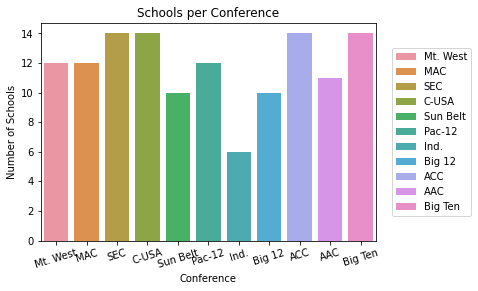

In [35]:
# Number of schools per conference. 
sns.countplot(x='ConferenceM', data=coach_records_stadium_grad_df, hue='ConferenceM', dodge=False)
_ = plt.xlabel('Conference')
_ = plt.ylabel('Number of Schools')
_ = plt.title('Schools per Conference')
_ = plt.legend(loc='center right', bbox_to_anchor=[1.3, 0.5])
_ = plt.xticks(rotation=17)
plt.show()

It looks like the SEC,C-USA, ACC, and BIg Ten have the most team all at 14.  There are three other conferences that have 12 teams and those are Mt. West., MAC, and PAC-12.  The remaining conferences are spread between 6 - 11.

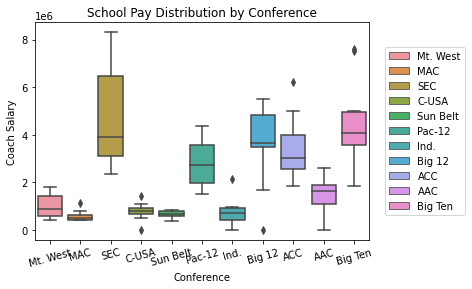

In [36]:
sns.boxplot(x='ConferenceM', y='SchoolPay', data=coach_records_stadium_grad_df, hue='ConferenceM', dodge=False)
_ = plt.legend(loc='center right', bbox_to_anchor=[1.3, 0.5])
_ = plt.xlabel('Conference')
_ = plt.ylabel('Coach Salary')
_ = plt.title('School Pay Distribution by Conference')
_ = plt.xticks(rotation=15)
plt.show()

The SEC and the Big Ten pay their coaches the most. With the ACC and Big-12 paying slightly lower.  

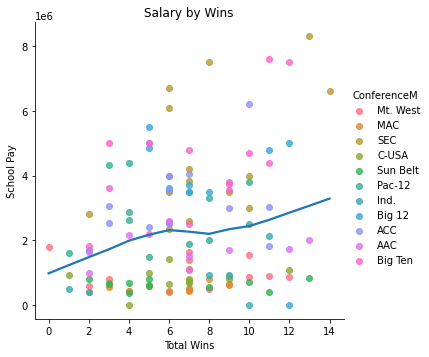

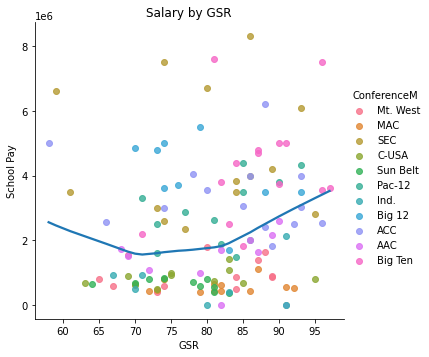

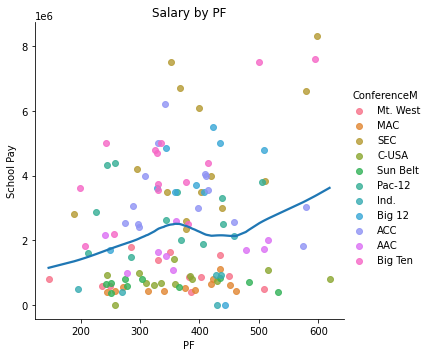

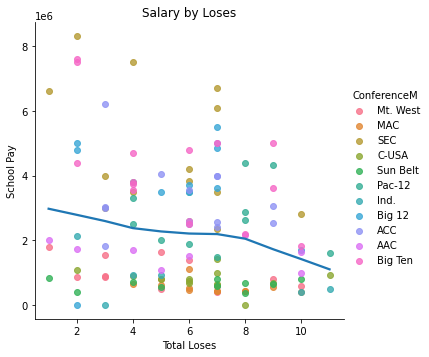

In [39]:
## Build an lm plot with loess regression ##
##  Total Wins by School Salary ##
a = sns.lmplot(x='W', y='SchoolPay', data=coach_records_stadium_grad_df, hue='ConferenceM', fit_reg=False)
sns.regplot(x='W', y='SchoolPay', data=coach_records_stadium_grad_df, scatter=False, ax=a.axes[0,0], lowess=True)
_ = plt.title('Salary by Wins')
_ = plt.xlabel('Total Wins')
_ = plt.ylabel('School Pay')
plt.show()

# Total pay by GSR
b = sns.lmplot(x='GSR', y='SchoolPay', data=coach_records_stadium_grad_df, hue='ConferenceM', fit_reg=False)
sns.regplot(x='GSR', y='SchoolPay', data=coach_records_stadium_grad_df, scatter=False, ax=b.axes[0,0], lowess=True)
_ = plt.title('Salary by GSR')
_ = plt.xlabel('GSR')
_ = plt.ylabel('School Pay')
plt.show()

# Total pay by PF
c = sns.lmplot(x='PF', y='SchoolPay', data=coach_records_stadium_grad_df, hue='ConferenceM', fit_reg=False)
sns.regplot(x='PF', y='SchoolPay', data=coach_records_stadium_grad_df, scatter=False, ax=c.axes[0,0], lowess=True)
_ = plt.title('Salary by PF')
_ = plt.xlabel('PF')
_ = plt.ylabel('School Pay')
plt.show()

# Total pay by losses ##
d = sns.lmplot(x='L', y='SchoolPay', data=coach_records_stadium_grad_df, hue='ConferenceM', fit_reg=False)
sns.regplot(x='L', y='SchoolPay', data=coach_records_stadium_grad_df, scatter=False, ax=d.axes[0,0], lowess=True)
_ = plt.title('Salary by Loses')
_ = plt.xlabel('Total Loses')
_ = plt.ylabel('School Pay')
plt.show()

Based on what we see above, Wins, Points Scored, and Graduation Rates are big factors in getting a bigger salary.  Let's look at some more insights by exploring Stadium Capacity and Points Against.

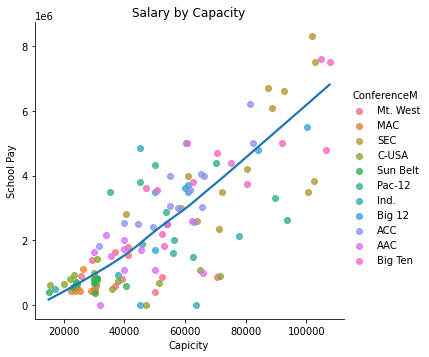

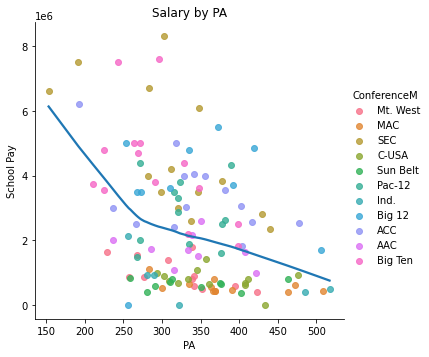

In [41]:
## Add more visual insight ##

# Total pay by Stadium Capacity ##
e = sns.lmplot(x='Capacity', y='SchoolPay', data=coach_records_stadium_grad_df, hue='ConferenceM', fit_reg=False)
sns.regplot(x='Capacity', y='SchoolPay', data=coach_records_stadium_grad_df, scatter=False, ax=e.axes[0,0], lowess=True)
_ = plt.title('Salary by Capacity')
_ = plt.xlabel('Capicity')
_ = plt.ylabel('School Pay')
plt.show()

# Total pay by PA
f = sns.lmplot(x='PA', y='SchoolPay', data=coach_records_stadium_grad_df, hue='ConferenceM', fit_reg=False)
sns.regplot(x='PA', y='SchoolPay', data=coach_records_stadium_grad_df, scatter=False, ax=f.axes[0,0], lowess=True)
_ = plt.title('Salary by PA')
_ = plt.xlabel('PA')
_ = plt.ylabel('School Pay')
plt.show()

The Stadium Capacity shows the larger stadiums have higher salaries.  That would makes sense, teams that invest in bigger stadiums expect to win and pay coaches more.  Points againts doesn't look to provide any real insights.


Let's start to build the model and see if we can determine salary of coaches

In [42]:
## Building the model ## 
final_datamodel_df = coach_records_stadium_grad_df[['SchoolM', 'SchoolPay', 'ConferenceM', 'Coach', 'W', 'L', 'PF', 'PA', 'AVG_POINTS_PER _GAME', 'DEF_ AVG_POINTS_PER _GAME', 'Capacity', 'GSR', 'FGR']]

## All of the fields used in the model are numeric, expect Conference (School is the target variable) ##
## Convert the conference to a numercial field using Label Encoder ##
Laben = LabelEncoder()
final_datamodel_df.loc[:, 'ConferenceM'] = Laben.fit_transform(final_datamodel_df['ConferenceM'])

## Check that Conference is numerical ## 
final_datamodel_df.head()
print(final_datamodel_df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 128
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SchoolM                    129 non-null    object 
 1   SchoolPay                  129 non-null    float64
 2   ConferenceM                129 non-null    int64  
 3   Coach                      129 non-null    object 
 4   W                          126 non-null    float64
 5   L                          126 non-null    float64
 6   PF                         126 non-null    float64
 7   PA                         126 non-null    float64
 8   AVG_POINTS_PER _GAME       126 non-null    float64
 9   DEF_ AVG_POINTS_PER _GAME  126 non-null    float64
 10  Capacity                   127 non-null    float64
 11  GSR                        128 non-null    float64
 12  FGR                        128 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 

In [43]:
## Select all the numeric columns ## 
final_datamodel_df_num_columns = ['ConferenceM']

# Change to numeric ## 
for i in final_datamodel_df_num_columns:
    final_datamodel_df[i] = final_datamodel_df[i].astype(float)

print(final_datamodel_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 128
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SchoolM                    129 non-null    object 
 1   SchoolPay                  129 non-null    float64
 2   ConferenceM                129 non-null    float64
 3   Coach                      129 non-null    object 
 4   W                          126 non-null    float64
 5   L                          126 non-null    float64
 6   PF                         126 non-null    float64
 7   PA                         126 non-null    float64
 8   AVG_POINTS_PER _GAME       126 non-null    float64
 9   DEF_ AVG_POINTS_PER _GAME  126 non-null    float64
 10  Capacity                   127 non-null    float64
 11  GSR                        128 non-null    float64
 12  FGR                        128 non-null    float64
dtypes: float64(11), object(2)
memory usage: 19.1+ KB
N

In [44]:
## Build the model ##
## Select Train and Test Data ##
model_input = ['ConferenceM', 'W', 'L', 'PF', 'PA', 'AVG_POINTS_PER _GAME', 'DEF_ AVG_POINTS_PER _GAME', 'Capacity', 'GSR', 'FGR']
target_output = ['SchoolPay']

## Build the validation data set ##
validation_input = final_datamodel_df[final_datamodel_df['SchoolM']=='Syracuse']
final_datamodel_2_df= final_datamodel_df[final_datamodel_df['SchoolM']!='Syracuse']

# Build training and testing sets
X_train, X_test, y_train, y_test = train_test_split(final_datamodel_2_df[model_input], final_datamodel_2_df[target_output], 
                                                   test_size=0.33, random_state=42)



In [115]:
final_datamodel_df[final_datamodel_df['SchoolM']=='Syracuse']


,SchoolM,SchoolPay,ConferenceM,Coach,W,L,PF,PA,AVG_POINTS_PER _GAME,DEF_ AVG_POINTS_PER _GAME,Capacity,GSR,FGR
102,Syracuse,2401206.0,1.0,Dino Babers,5.0,7.0,299.0,316.0,24.9,26.3,49250.0,88.0,76.0


In [101]:
# TBuild the model ##
model_test_1 = ('SchoolPay ~ ConferenceM + W + L + PF + PA + Capacity + GSR + FGR')
model_output = smf.ols(model_test_1, data=final_datamodel_df).fit()
model_output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SchoolPay   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     27.84
Date:                Sun, 30 Jan 2022   Prob (F-statistic):           1.57e-23
Time:                        22:20:17   Log-Likelihood:                -1886.3
No. Observations:                 123   AIC:                             3791.
Df Residuals:                     114   BIC:                             3816.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.607e+06    1.7e+06     -0.946      0.346   -4.97e+06    1.76e+06
ConferenceM -3.426e+04   3.35e+04     -1.022      0.309   -1.01e+05    3.21e+04
W           -3.688e+04   9.72e+04     -0.380      0.705   -2.29e+05    1.56e+05
L            9.923e+04   1.11e+05      0.897      0.372    -1.2e+05    3.18e+05
PF           3021.5112   2120.352      1.425      0.157   -1178.891    7221.913
PA          -5239.2753   2355.957     -2.224      0.028   -9906.408    -572.143
Capacity       59.3206      4.930     12.033      0.000      49.555      69.086
GSR          1.193e+04   1.39e+04      0.860      0.392   -1.56e+04    3.94e+04
FGR          7544.1286   8336.636      0.905      0.367   -8970.682    2.41e+04
==============================================================================
Omnibus:                        1.453   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.484   Jarque-Bera (JB):                0.979
Skew:                          -0.117   Prob(JB):                        0.613
Kurtosis:                       3.369   Cond. No.                     9.36e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looks like our first model has an R-squared of 0.661, much to my suprise Wins (W) and Loses(L) were not as important as I thought.  Let's drop the graduation data and see what impact that has.

In [134]:
model_test_2 = ('SchoolPay ~ ConferenceM + W + L + PF + PA + Capacity  FGR + GSR')
model_output_2 = smf.ols(model_test_2, data=final_datamodel_2_df).fit()
model_output_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SchoolPay   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     4.993
Date:                Sun, 30 Jan 2022   Prob (F-statistic):           5.67e-05
Time:                        23:34:24   Log-Likelihood:                -1968.1
No. Observations:                 125   AIC:                             3952.
Df Residuals:                     117   BIC:                             3975.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.845e+06   2.46e+06      1.158      0.249   -2.02e+06    7.71e+06
ConferenceM -6.371e+04   5.01e+04     -1.272      0.206   -1.63e+05    3.55e+04
W           -1.141e+05   1.45e+05     -0.786      0.433   -4.01e+05    1.73e+05
L            1.657e+05   1.65e+05      1.002      0.318   -1.62e+05    4.93e+05
PF           7589.0534   3098.529      2.449      0.016    1452.580    1.37e+04
PA          -1.459e+04   3255.780     -4.480      0.000    -2.1e+04   -8137.319
FGR          1582.8775   1.25e+04      0.127      0.899   -2.31e+04    2.63e+04
GSR          2.096e+04   2.05e+04      1.021      0.310   -1.97e+04    6.16e+04
==============================================================================
Omnibus:                        6.686   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                6.885
Skew:                           0.571   Prob(JB):                       0.0320
Kurtosis:                       2.875   Cond. No.                     8.21e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Dropping GSR did lower the r-square but only by .02 . It does have an impact but very minimal, we will keep it in our model.

## **Answer the following questions in your report:**

**What is the recommended salary for the Syracuse football coach?**

In [117]:
syr = final_datamodel_df.loc[final_datamodel_df['SchoolM'] == 'Syracuse']
model_output.predict(syr)

102    2.661306e+06
dtype: float64

**What would his salary be if we were still in the Big East? What if we went to the Big Ten?**

1.   The Big East does not exist anymore so I'm not sure how to answer this one.
2.   The Salary of the Syracuse coach if he was in the Big 10 would be ~2.8M ** 

In [125]:
coach_records_stadium_grad_df[coach_records_stadium_grad_df['ConferenceM']=='Big Ten']

,SchoolM,ConferenceM,Coach,SchoolPay,W,L,PF,PA,AVG_POINTS_PER _GAME,DEF_ AVG_POINTS_PER _GAME,Capacity,GSR,FGR
42,Illinois,Big Ten,Lovie Smith,5000000.0,5.0,7.0,242.0,263.0,20.2,21.9,60670.0,91.0,79.0
43,Indiana,Big Ten,Tom Allen,1830000.0,2.0,10.0,207.0,399.0,17.3,33.3,52959.0,85.0,62.0
44,Iowa,Big Ten,Kirk Ferentz,4700000.0,10.0,4.0,328.0,269.0,23.4,19.2,70585.0,87.0,65.0
57,Maryland,Big Ten,DJ Durkin,2512000.0,7.0,6.0,381.0,399.0,29.3,30.7,54000.0,83.0,73.0
62,Michigan,Big Ten,Jim Harbaugh,7504000.0,12.0,2.0,501.0,243.0,35.8,17.4,107601.0,96.0,79.0
63,Michigan State,Big Ten,Mark Dantonio,4390417.0,11.0,2.0,414.0,329.0,31.8,25.3,75005.0,84.0,68.0
65,Minnesota,Big Ten,P.J. Fleck,3550000.0,9.0,4.0,331.0,225.0,25.5,17.3,50805.0,96.0,78.0
70,Nebraska,Big Ten,Scott Frost,5000000.0,3.0,9.0,335.0,272.0,27.9,22.7,92000.0,90.0,65.0
79,Northwestern,Big Ten,Pat Fitzgerald,3619775.0,3.0,9.0,199.0,348.0,16.6,29.0,47130.0,97.0,94.0
82,Ohio State,Big Ten,Urban Meyer,7600000.0,11.0,2.0,594.0,296.0,45.7,22.8,104944.0,81.0,53.0


**What schools did we drop from our data and why?**

In the "Coaches" Data set these were the only college that didnt have any salary data, I elminted them from the data set.


1.   Baylor
2.   Southern Methodist
3.   Rice
4.   Brigham Young




**What effect does graduation rate have on the projected salary?**

Dropping GSR did lower the r-square but only by .02 . It does have an impact but very minimal.

R-Squared with GSR = 0.661
R-Squared with out GSR = 0.659




**How good is our model?**

The model has an R-squared of 0.661 and the prediction for the Syracuse coach was off $260k, which was ~11% off the actual salary amount.  So overall, I would say the model does ok.  It should give the user a good starting point if all variables are known.


In [ ]:
model_test_1 = ('SchoolPay ~ ConferenceM + W + L + PF + PA + Capacity + GSR + FGR')
model_output = smf.ols(model_test_1, data=final_datamodel_df).fit()
model_output.summary()

**What is the single biggest impact on salary size?**

This biggest impact on my model was Capacity.  This impacted my R-sqaured by ~65%

1.   With Capacity as a variable, R-Squared = 0.661
2.   Without Capacity as a variable, R-Squared = 0.230


Bonus
**Develop a geographic visualization that in your view best depicts the conferences median salary**

The black line in each box represents the median salary for each conference


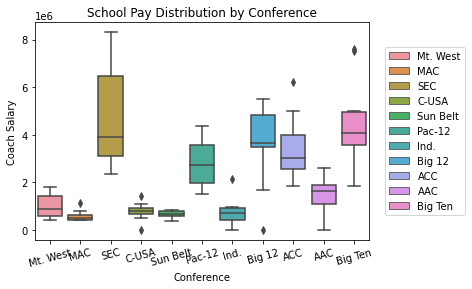

In [135]:
sns.boxplot(x='ConferenceM', y='SchoolPay', data=coach_records_stadium_grad_df, hue='ConferenceM', dodge=False)
_ = plt.legend(loc='center right', bbox_to_anchor=[1.3, 0.5])
_ = plt.xlabel('Conference')
_ = plt.ylabel('Coach Salary')
_ = plt.title('School Pay Distribution by Conference')
_ = plt.xticks(rotation=15)
plt.show()